SEP uses the "core algorithms" of Source Extractor as a python library of functions and classes (see Barbary 2016). 

# Install

with conda:

with pip

# Read image

In [2]:
%matplotlib inline
import numpy as np
import sep
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from matplotlib.patches import Ellipse

We'll read in the fits image using astropy.io.fits. In doing so you might get the error: 

You should then perform the byte swap operation below. If you're using fitsio this error probably won't occur

In [3]:
fname = 'simple_sim_cube_F090W_487_01.slp.fits'
hdu_list = fits.open(fname, do_not_scale_image_data=True)
tbdat = hdu_list[0].data
hdu_list.close()
tbdat = tbdat.byteswap().newbyteorder() #byte swap operation

# Plot original image

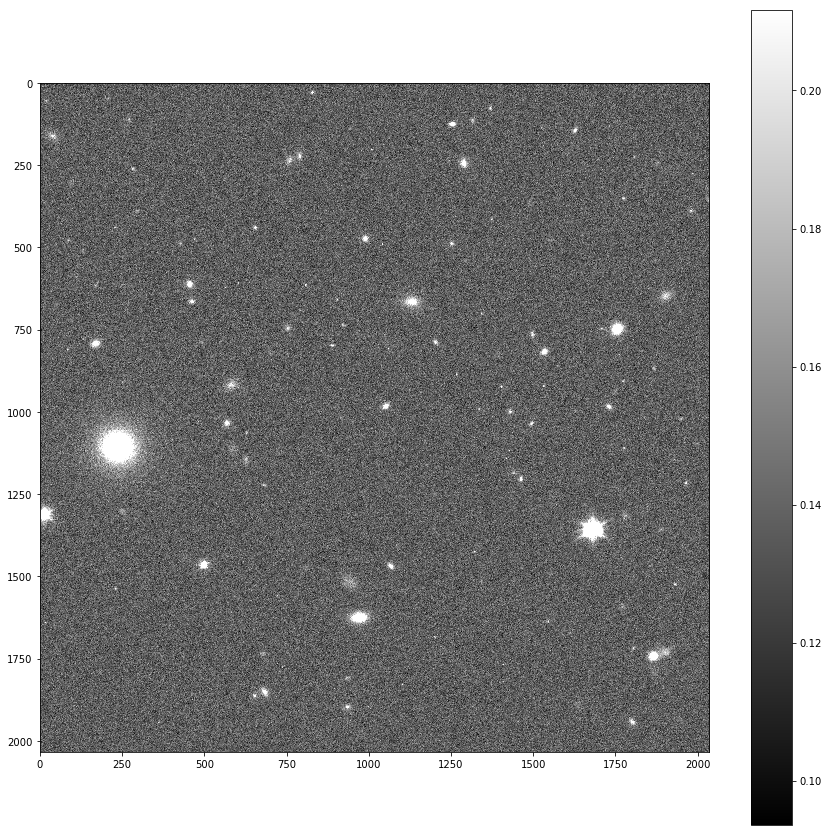

In [4]:
plt.figure(figsize=[15,15])
plt.imshow(tbdat, interpolation='nearest', cmap='gray', vmin=0.093537331, vmax=0.21167476, origin='upper')
plt.colorbar()

# Subtract Background

The background subtraction, sep.Background(), does allow for masking as well as filter dimension parameters. Let's find the background first.

In [5]:
bkg = sep.Background(tbdat)
print(bkg.globalback) #gives global mean of background
print(bkg.globalrms) #gives global noise of background
bkg_img = bkg.back() #2d array of background
print(bkg_img.shape)

tbdat_sub = tbdat - bkg


0.137105196714
0.0122048910707
(2036, 2036)


Plot the background

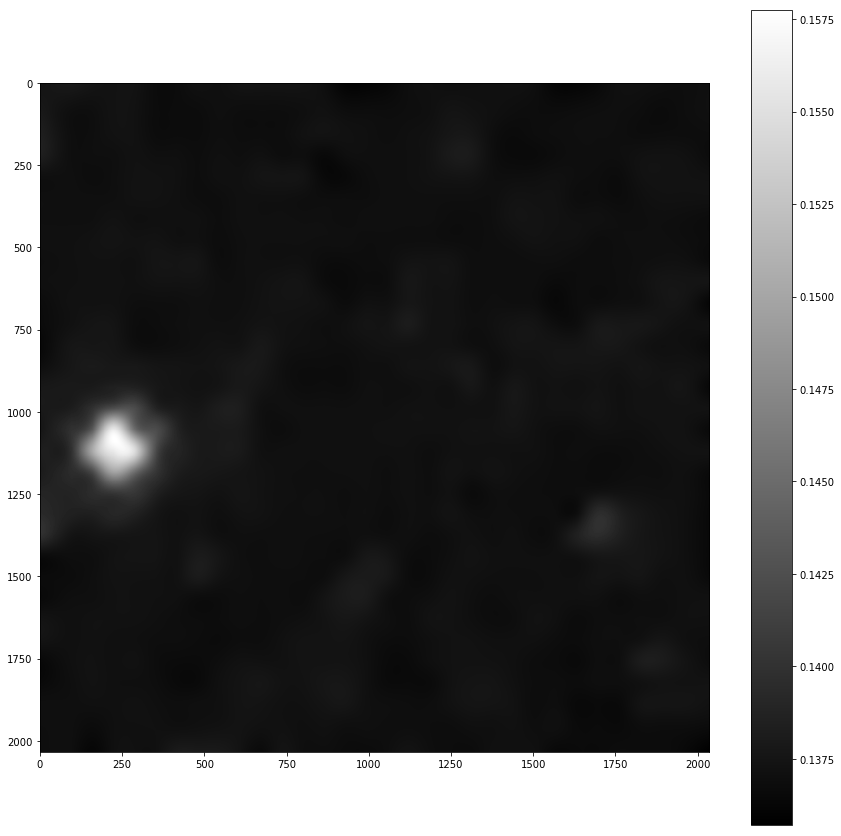

In [6]:
plt.figure(figsize=[15,15])
plt.imshow(bkg_img, interpolation='nearest', cmap='gray', origin = 'upper')
plt.colorbar()

# Extraction

Here we perform the object detection, where 'thresh' is the detection threshold. A detected object is distinguished at this threshold (e.g 2.0*err). 

In [7]:
objects = sep.extract(tbdat_sub, thresh=2.0, err = bkg.globalrms)
print'Number of objects detected: ', len(objects)

Number of objects detected:  155


objects will have the following object parameters:

* thresh (float) Threshold at object location.
* npix (int) Number of pixels belonging to the object.
* tnpix (int) Number of pixels above threshold (unconvolved data).
* xmin, xmax (int) Minimum, maximum x coordinates of pixels.
* ymin, ymax (int) Minimum, maximum y coordinates of pixels.
* x, y (float) object barycenter (first moments).
* x2, y2, xy (float) Second moments.
* errx2, erry2, errxy (float) Second moment errors. Note that these will be zero if error is not given.
* a, b, theta (float) Ellipse parameters, scaled as described by Section 8.4.2 in “The Source Extractor Guide” or   Section 10.1.5-6 of v2.13 of SExtractor’s User Manual.
* cxx, cyy, cxy (float) Alternative ellipse parameters.
* cflux (float) Sum of member pixels in convolved data.
* flux (float) Sum of member pixels in unconvolved data.
* cpeak (float) Peak value in convolved data.
* peak (float) Peak value in unconvolved data.
* xcpeak, ycpeak (int) Coordinate of convolved peak pixel.
* xpeak, ypeak (int) Coordinate of unconvolved peak pixel.
* flag (int) Extraction flags.

(see Baraby 2016)

We can also plot ellipses over the objects for a nice visual.

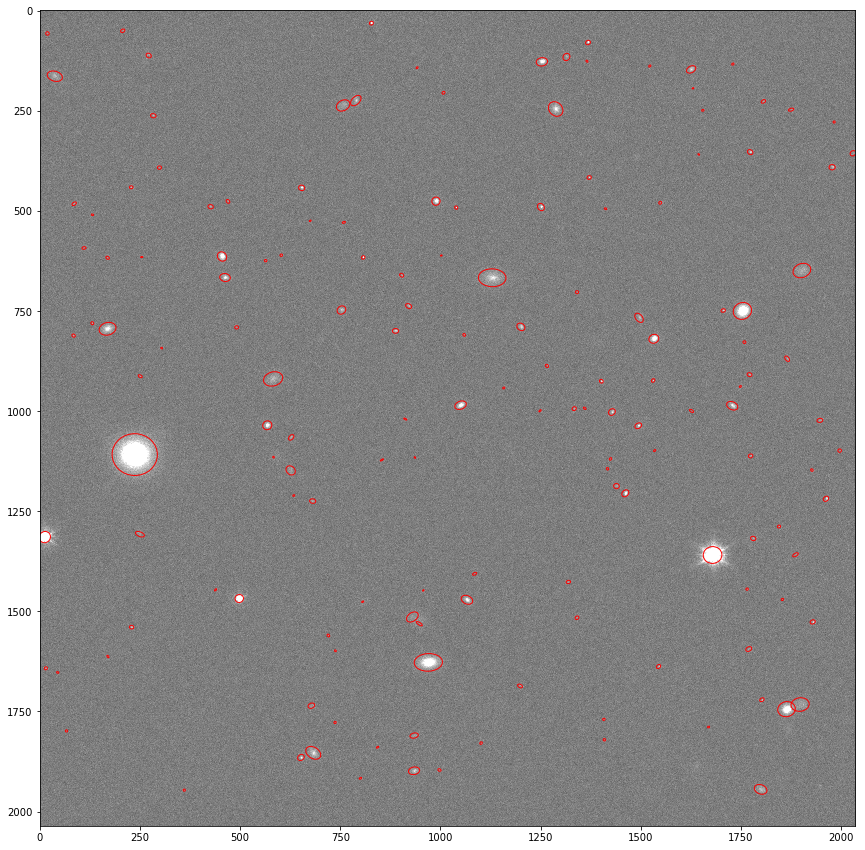

In [8]:
#pulled from Baraby2016
fig, ax = plt.subplots(figsize=[15,15])
m, s = np.mean(tbdat_sub), np.std(tbdat_sub)
im = ax.imshow(tbdat_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='upper')
for i in range(len(objects)):
        e = Ellipse(xy=(objects['x'][i], objects['y'][i]), width = 6*objects['a'][i], height = 6*objects['b'][i], angle = objects['theta'][i]*108/np.pi)
        e.set_edgecolor('red')
        e.set_facecolor('none')
        ax.add_artist(e)

# Let's do some photometry

We'll perform elliptical aperture photometry for objects within the Kron radius defined by
$$\sum_{i} r_{i}I(r_{i})/\sum_{i}I(r_{i})$$
Here $r_{i}$ is the distance to the pixeld from the ellipse. he Kron aperature photometry is a proposed technique that captures the majority of the flux.

sep.kron_radius() uses an object's x, y, and elliptical properties, along with the elliptical radius (r) which is integrated over. 

First let's find the Kron radius.

In [9]:
kronrad, kronflag = sep.kron_radius(tbdat_sub, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], r=6.0)

Next we'll perform the elliptical aperture photometry. 

In [10]:
flux, fluxerr, flag = sep.sum_ellipse(tbdat_sub, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], r = (2.5*kronrad), err = bkg.globalrms, subpix=1)
flag |=kronflag #combines flags
r_min = 1.75 #minimum diameter = 3.5

Now we'll perform circular aperture photometry for sources that don't meet the Kron radius criteria. This process is equivalent to the FLUX_AUTO option in SExtractor. 

In [13]:
use_circle = kronrad*np.sqrt(objects['a']*objects['b']) < r_min
cflux, cfluxerr, cflag = sep.sum_circle(tbdat_sub, objects['x'][use_circle], objects['y'][use_circle], r_min, subpix=1)
flux[use_circle] = cflux
fluxerr[use_circle] = cfluxerr
flag[use_circle] = cflag

We can find the radius of a circle contianing a percentage of the total flux of the object.

In [14]:
r, rflag = sep.flux_radius(tbdat_sub, objects['x'], objects['y'], rmax = 6.0*objects['a'], frac = 0.5, normflux = flux, subpix =5)


We can convert the flux to AB mags. 

In [15]:
hdu_list = fits.open(fname, do_not_scale_image_data=True)
zero_point = hdu_list[0].header['ABMAG']
mag = -2.5*np.log10(flux) + zero_point

Let's get the RA & DEC of our extracted objects

In [22]:
hdu_list = fits.open(fname)
w = wcs.WCS(hdu_list[0].header)
hdu_list.close()
wrd = w.wcs_pix2world(objects['x'], objects['y'], np.zeros(len(objects['x'])), 0) 
ra = wrd[:][0]
dec = wrd[:][1]

Print objects by increasing magnitude with coordinates.

In [29]:
index = sorted(range(len(mag)), key=lambda k: mag[k])
print "ABMag", "\t\t", "RA", "\t", "\t", "DEC"
for j in range(0,125):
    k = index[j]
    print mag[k], "\t", ra[k], "\t", dec[k]

ABMag 		RA 		DEC
18.4338175303 	53.1179572388 	-27.8021195522
18.6922874897 	53.1038187917 	-27.8041250348
19.4646746852 	53.1016530735 	-27.8023052686
21.0839726351 	53.1186003597 	-27.8074310079
21.1223685721 	53.1064193419 	-27.8010303207
21.1612215212 	53.1110567529 	-27.7997004726
21.5547758626 	53.1201448023 	-27.7988975445
21.7200067276 	53.1198153904 	-27.7987930171
21.8422955969 	53.1124821238 	-27.8080752336
22.5117728202 	53.1164486117 	-27.8067989968
22.5919543589 	53.1058802678 	-27.808455173
22.6971715528 	53.103111525 	-27.8068496128
22.742517473 	53.1071695087 	-27.8058111926
22.8568470333 	53.120038775 	-27.8083262966
22.8640084283 	53.1139730663 	-27.8117612544
22.9021623923 	53.1087836893 	-27.8117738983
22.9541450837 	53.1117540581 	-27.8052975087
23.0088984105 	53.1110830653 	-27.8097221797
23.0268294414 	53.1082792878 	-27.7977005734
23.2603633296 	53.1070428929 	-27.8048023407
23.2724052034 	53.1017358241 	-27.8123211407
23.2837868966 	53.11065184 	-27.8006818351